In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import (metrics, model_selection, linear_model, preprocessing, ensemble, neighbors, tree, decomposition)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pydotplus
import seaborn as sns
import numpy as np
import pandas as pd
import pprint as pp
import re
from sklearn.model_selection import train_test_split, cross_val_score
# vvv sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
# from xgboost import XGBClassifier,plot_tree,to_graphviz


In [2]:
from IPython.display import Image 

%matplotlib inline

# markdown syntax:
# https://daringfireball.net/projects/markdown/syntax#header

In [2]:
import os,sys

# attempted, didn't work:
# https://stackoverflow.com/a/39311677
# libdir=os.path.split(os.getcwd())[0]
# sys.path.append(os.getcwd())
# module_path = os.path.abspath(os.path.join('..'))
# https://stackoverflow.com/a/35273613

libpath="./code"
if libpath not in sys.path:
    sys.path.append('./code')

# import helpers
# helpers.print_test()

In [3]:
import txdot_parse as txpars
import helpers
import feature_definitions as ftdef

# TOC - Table of Contents

<!-- generate with helpers.py -->
*  [Introduction](#Introduction)

*  [Data Preparation](#Data-Preparation)

* *  [Preprocessing](#Preprocessing)

* *  [Impute Missing Values](#Impute-Missing-Values)

*  [Data Exploration](#Data-Exploration)

* *  [Visualisation](#Visualisation)

* *  [Maps of Crashes](#Maps-of-Crashes)

* *  [Feature Selection](#Feature-Selection)

* * *  [Decision Tree Classifier](#Decision-Tree-Classifier)

* * *  [Decision Tree Classifier CV](#Decision-Tree-Classifier-CV)

*  [Analysis](#Analysis)

* *  [XGB - Extreme Gradient Boosting](#XGB---Extreme-Gradient-Boosting)

* *  [Random Forest](#Random-Forest)

* *  [KNN: K Nearest Neighbours](#KNN:-K-Nearest-Neighbours)

* *  [XGB ROC CV Optimisation](#XGB-ROC-CV-Optimisation)

# Introduction

In 2015 the White House issued a challenge to data scientists to examine out why accidents increased drastically in 2015.

This announcment was made on a national level, which prompted our interest in what could be done at the local level.

In partiular, we were interested in the safety of bicycling in Austin.

Austin has been working on improving cycling safety for many years, and recently partnered with Vision Zero to eliminate all traffic fatalities.

This project examines which effect these ongoing efforts by the City of Austin have had on cycling safety.

# Data Preparation

## Preprocessing

The data for this project was downloaded from the TxDoT website, which requires one to manually select the data and download a CSV file.


The downloaded CSV file was not immediately machine readable.

E.g. missing data had various representations which all needed to be replaced by np.nan.

In [4]:
# import the "crash" data
data = pd.read_csv("data/my_map_grid.csv",header=10)

In [5]:
# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)

## Impute Missing Values

About 25% of the speed limits were not recorded.

However, we were able to imput about 5% of the speed limits by examining duplicate intersections.

It should be noted that the speed limits change over the years; when imputing speed limits, later values were preferred for back-fill over earlier values.

This could bias the values towards higher speed limits, but the delta is usually only 5mph at a time.

In [6]:
data.speed_limit.replace(0,np.nan,inplace=True)
data.speed_limit.replace(-1,np.nan,inplace=True)
# impute speed limits
print("########################################")
verbose=0
if(verbose):
    print(data.speed_limit.value_counts())
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("pre : total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
data = txpars.impute_mph(data, verbose=0)
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("post: total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
    print(data.speed_limit.value_counts())
    print(data.info())
print("########################################")

########################################
pre : total missing speed limit data:
 575 (0.2576164874551971 of 1)
post: total missing speed limit data:
 458 (0.20519713261648745 of 1)
########################################


# Data Exploration

## Visualisation

## Maps of Crashes

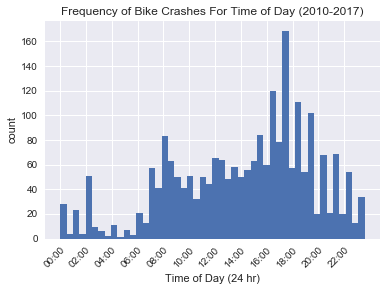

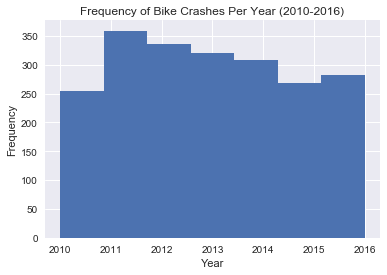

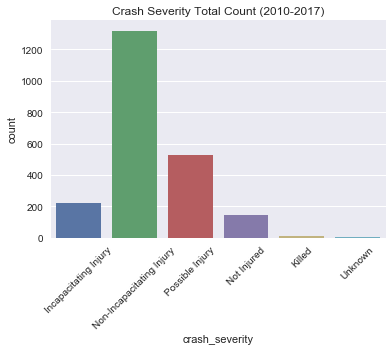

In [14]:
# Let's see the realationship between crashes and time of day
# First, let's just look at the total crashes vs time of day (no crash severity)

data = pd.read_csv("data/my_map_grid.csv",header=10)
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')

# add 
ax_time = helpers.get_ax_time(
        interval = '24h',
        title = 'Frequency of Bike Crashes For Time of Day (2010-2017)',
        xlabel = 'Time of Day (24 hr)',
        ylabel = 'count',
        )

data.crash_time.hist(bins=48,ax=ax_time)
plt.show()

# Let's see if there is a trend of total bike crashes by year
# We'll ignore 2017 data since it is incomplete
# histogram
if(1):
    data.crash_year[data.crash_year != 2017].plot.hist(bins=7)
    plt.xlabel('Year')
    plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
    plt.show()
# bar chart
else:
    plt.bar(data.crash_year[data.crash_year != 2017].value_counts().index, data.crash_year[data.crash_year != 2017].value_counts().values)
    plt.xlabel('Year')
    plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
    plt.show()

# Spread of Crash Severity data from 2010-2017
# Using seaborn for ease of use with categorical data
sns.countplot(x="crash_severity", data=data);
plt.xticks(rotation=45, rotation_mode="anchor",ha="right")
plt.title('Crash Severity Total Count (2010-2017)')
plt.show()

if(0):
    sns.countplot(x="street_name", data=data);
    plt.xticks(rotation=45, rotation_mode="anchor",ha="right")
    plt.title('Total Accidents by Street Name (2010-2017)')
    plt.show()

In [17]:
print("Total Crashes involving Severe Injuries and fatalities from 2010-2017")
import IPython
url = 'output/crashes.html'
iframe = '<iframe src=' + url + ' width=700 height=525></iframe>'
IPython.display.HTML(iframe)

Total Crashes involving Severe Injuries and fatalities from 2010-2017


Total Map of Crashes:

The clustering is expected for anyone familiar with Austin roads:

* Downtown area
* Riverside
* Congress
* Lamar
* Guadalupe

Very few severe accidents outside of the core area.

The subsequent maps investiage the spikes observed in the time-of-day bar-chart.

In [18]:
print("Morning+Daytime (500 - 1530): Total Crashes involving Severe Injuries and fatalities from 2010-2017")
import IPython
url = 'output/crashes_500_1530.html'
iframe = '<iframe src=' + url + ' width=700 height=525></iframe>'
IPython.display.HTML(iframe)

Morning+Daytime (500 - 1530): Total Crashes involving Severe Injuries and fatalities from 2010-2017


Crashes with Severe Injuries between 05:00 and 15:30

This looks roughly the same as the map of overall crashes, which is explained by the overall higher rate of incidents during these times.

In [19]:
print("Happy Hour (1530 - 1900) Total Crashes involving Severe Injuries and fatalities from 2010-2017")
import IPython
url = 'output/crashes_1530_1900.html'
iframe = '<iframe src=' + url + ' width=700 height=525></iframe>'
IPython.display.HTML(iframe)

Happy Hour (1530 - 1900) Total Crashes involving Severe Injuries and fatalities from 2010-2017


Crashes with Severe Injuries between 15:30 and 19:00

There are not as many severe injuries during this time, but do not the persistent clustering around down-town; this does not seem to change much as compared to the day-time map.

This could be due to the role downtown plays as a transit hub; most paths go through this area.

In [20]:
print("Night Time (1900 - 500): Total Crashes involving Severe Injuries and fatalities from 2010-2017")
import IPython
url = 'output/crashes_1900_500.html'
iframe = '<iframe src=' + url + ' width=700 height=525></iframe>'
IPython.display.HTML(iframe)

Night Time (1900 - 500): Total Crashes involving Severe Injuries and fatalities from 2010-2017


Crashes with Severe Injuries between 19:00 and 05:00

The bar-chart showed an overall decrease during this time.

Note the increase in accidents around down-town, which could correspond to the spikes observed around 2 am in the chart as bars close.

## Feature Selection


The features were split into continuous and non-continuous categories.

Some features require dummy-encoding

In [ ]:
smalldf = data[['crash_severity', 
                'intersection_related', 
                'light_condition', 
                'manner_of_collision',
                'surface_condition', 
                'weather_condition']]

smalldf.head()

dummies_needed_list = [
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'surface_condition',
 'weather_condition']

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    smalldf = pd.concat([smalldf,pd.get_dummies(smalldf[feat],prefix=feat)],axis=1)
    smalldf = smalldf.drop([feat],axis=1)
    
smalldf.head()
X = smalldf.drop(['crash_severity'], axis=1)
y = smalldf['crash_severity']

### Decision Tree Classifier

The dataset is highly categorical, which lends itself well to a tree classifier.


For initial data exploration, a decision tree classifier was used for it's explainability to gain better insight into the model.

The resulting confusion matrix indicated that this was a step in the right direction. 


In [14]:
# import the "crash" data
datafile = "data/my_map_grid.csv"

# get clean data
(data,featdef) = txpars.preprocess_data(datafile)

# add binary categories
(data,featdef) = txpars.preproc_add_bin_categories(data, featdef, verbose=0)

# get dummies
(data_dummies,featdef) = ftdef.featdef_get_dummies(data,featdef)
# data_dummies.head()

In [15]:
print("-I-: DecisionTree")
# valid features - defined for regression (aka classification), are integers (because I'm really into that), and ain't supposed to be no dummy (entries meant to be encoded as dummies)
# 'regtype ! = False' mainly for crash_id
# TODO - change crash_year to regtype == False
validfeats = featdef[(featdef.regtype != False) & (featdef.type == 'int') & (featdef.dummies == False)]
# define predictors and response
predictors  = list(featdef[(featdef.regtype != False) & (featdef.target != True) & (featdef.dummies == False) & (featdef.regtype != 'bin_cat') & (featdef.type == 'int') & ((featdef.index != 'average_daily_traffic_amount') & (featdef.index != 'average_daily_traffic_year')) ].index)
responsecls = list(featdef[(featdef.regtype != False) & (featdef.target == True) & (featdef.dummies == False) & (featdef.regtype != 'bin_cat') & (featdef.type == 'int') & (featdef.origin == 'crash_severity')].index)

if(0):
    print("##############")
    print("predictors:")
    print(predictors)
    print("responsecls:")
    print(responsecls)
    print("##############")



-I-: DecisionTree


In [ ]:
print("-I-: train-test split")
testsize = 0.3
# get dummies for this particular case
data_dummies_firstplot = data_dummies[ predictors + responsecls ].dropna()
# re-combine dummies with idxmax 
#+ src: https://stackoverflow.com/a/38334528
X_full = data_dummies_firstplot[predictors]
y_full = data_dummies_firstplot[responsecls].idxmax(1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full,y_full, test_size=testsize, random_state=42)


# print(X_full.columns)
# print(y_full)


clf = tree.DecisionTreeClassifier() #max_depth = 5)
# use full dataset for feature selection

# raw
#clf.fit(X_full,y_full)
#cm = confusion_matrix(y_test,clf.predict(X_full))
#helpers.plot_confusion_matrix(cm,classes=clf.classes_)

# train/test
clf.fit(X_train,y_train)


Confusion matrix, without normalization


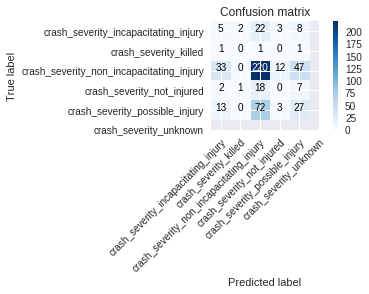

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,clf.predict(X_test))
helpers.plot_confusion_matrix(cm,classes=clf.classes_)

### Decision Tree Classifier CV

The Cross-Validation Decision Tree Classifier continues with the feature selection.

The goal here is to balance automatic feature reduction (backwards feature selection) with manual feature selection (removing features which seem to be overrepresented)

In [57]:
# import the "crash" data
datafile = "data/my_map_grid.csv"

# get clean data
(data2,featdef) = txpars.preprocess_data(datafile)

# add binary categories
(data2,featdef) = txpars.preproc_add_bin_categories(data2, featdef, verbose=0)

# get dummies
(data_dummies,featdef) = ftdef.featdef_get_dummies(data2,featdef)

In [ ]:
def run_cross_val(data_dummies,featdef,dropfeatures=[]):
    validfeats = featdef[(featdef.dummies == False) & (featdef.type == 'int')]
    if(len(dropfeatures) >0):
        validfeats = validfeats.drop(dropfeatures)
    data_int_list = list(validfeats.index)
    df_int = data_dummies[list(validfeats.index)]
    # Avoid: ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
    df_int_nonan = df_int.dropna()
    print("NaN handling: Samples: NaN data %d / %d fullset => %d newset" % ( (df_int.shape[0] - df_int_nonan.shape[0]) , df_int.shape[0] , df_int_nonan.shape[0]))
    if(df_int_nonan.shape[1] == df_int.shape[1]):
      print("NaN handling: no  feature reduction after dropna(): pre %d , post %d " % (df_int_nonan.shape[1] , df_int.shape[1]))
    else:
      print("NaN handling: !!! FEATURE REDUCTION after dropna(): pre %d , post %d " % (df_int_nonan.shape[1] , df_int.shape[1]))
    if(1):
        print("-I-: DecisionTree 1")
        # further prune valid features - mainly get rid of crash_id
        validfeats = validfeats[validfeats.regtype != False] # only invalid values are False
        predictors  = list(validfeats[(validfeats.target != True) & (validfeats.regtype != 'bin_cat')].index)
        responsecls = list(validfeats[(validfeats.target == True) & (validfeats.regtype == 'bin_cat')].index)
    print("-I-: DecisionTree - feature selection")
    from sklearn.model_selection import StratifiedKFold,GroupKFold
    from sklearn.feature_selection import RFECV
    from sklearn import tree
    clf = tree.DecisionTreeClassifier(random_state = 42) #max_depth = 5)
    # use full dataset for feature selection
    X_full = df_int_nonan[predictors]
    y_full = df_int_nonan[responsecls]

    print("-I-: DecisionTree - feature selection")
    if(0):
      dectree_evaluate_cv_strategy(X_full, y_full)
    else:
      print("-I-: ... skipping")

    print("-I-: previously chosen: StratifiedKFold with roc_auc_score")
    # settling on ...
    cvFold = StratifiedKFold
    rfecv = RFECV(estimator=clf, step=1, cv=cvFold(2), scoring='roc_auc')
    rfecv.fit(X_full,y_full.values.ravel())

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    # TODO: plot the feature names at 45deg angle under the numbers
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    print("Optimal number of features : %d" % rfecv.n_features_)

    # print important features
    print("-I-: most important features:")
    clf_imp_feats = helpers.print_model_feats_important(rfecv.estimator_, predictors, 0)
    ax = helpers.get_ax_barh(clf_imp_feats, title="DecisionTree Important Features")
    plt.show()

    print("-I-: examining most important features:")
    print("ratio  score   non-nan total feature")
    for i,feat in enumerate(clf_imp_feats.index):
        num_not_nan = data_dummies[~data_dummies[feat].isnull()].shape[0] # data_dummies[feat].count() wooudl work too
        print("%0.4f %0.4f %5d %5d %s" % (num_not_nan/ data_dummies.shape[0], clf_imp_feats[i], num_not_nan, data_dummies.shape[0], feat))
    #plt.bar(data_dummies.crash_year.value_counts().index,data_dummies.crash_year.value_counts().values) ; plt.show()
run_cross_val(data_dummies, featdef)
run_cross_val(data_dummies, featdef, ['average_daily_traffic_amount','crash_year'])
run_cross_val(data_dummies, featdef, ['average_daily_traffic_amount','average_daily_traffic_year','crash_year'])

# Analysis

## Random Forest

## KNN: K Nearest Neighbours

## XGB ROC CV Optimisation